# Taller Clasificación de Hablantes
En este taller se dispone de fragmentos de audios pertenecientes a distintos senadores, el objetivo consta de lograr identificar a los hablantes haciendo uso de redes LSTM y tecnicas como dropout y regularizacion.

In [ ]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical

from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

speechs = '/content/drive/MyDrive/universidad/train/' 

Mounted at /content/drive


In [ ]:
sppechs_directory = os.listdir(speechs)

file_speecher = []
file_path = []

for dir in sppechs_directory:
    print(dir)
    speeches = os.listdir(speechs + dir)
    for wav_file in speeches:
        file_speecher.append(dir)
        file_path.append(speechs + dir + '/' + wav_file)
        
# dataframe for emotion of files
speecher_df = pd.DataFrame(file_speecher, columns=['speechers'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['path'])
speech_df = pd.concat([speecher_df, path_df], axis=1)

amy_zillah_elsie
alice_elizabeth
anna_kristine
anna_sofia
annie_clemmer
agda_thorilda_viktoria
augusta_maria
alice_phoebe
ann_elizabeth
augusta_charlotta
caroline_louise
bridget_mary
brigdet_delia
bertram_frank
charles_h
austin_blyler
bengt_edvin
charles_joseph
carla_christine_nielsine
aurora_adelia
daniel_j
douglas_bullen
clear_annie
constance_mirium
eberhard_thelander
david_john
domingos_fernandeo
constance_gladys
daisy_e
ebba_iris_alfrida
edwy_arthur
edgar_joseph
edvard_bengtsson
edward_pennington
eleanor_ileen
elisabeth_walton
elizabeth_mussey
elizabeth_margaret
eino_william
edward_arthur
ernest_james
ellis_anna_maria
emily_borie
erik_gustaf
elizabeth_w
engelhart_cornelius
ernesti_arvid
erna_alexandra
ellen_natalia
ernest_portage
frederick_charles
francis_william
frederic_kimber
georgette_alexandra
eugene_patrick
frans_olof
ernst_gilbert
farred_chehab
francisco_m
eva_miriam
harriet_r
george_b
george_achilles
hans_linus
gerda_ulrika
gustave_j
gertrude_maybelle
gretchen_fiske
harry_m

In [ ]:
speech_df.head()

,speechers,path
0,amy_zillah_elsie,/content/drive/MyDrive/universidad/train/amy_z...
1,amy_zillah_elsie,/content/drive/MyDrive/universidad/train/amy_z...
2,amy_zillah_elsie,/content/drive/MyDrive/universidad/train/amy_z...
3,amy_zillah_elsie,/content/drive/MyDrive/universidad/train/amy_z...
4,alice_elizabeth,/content/drive/MyDrive/universidad/train/alice...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


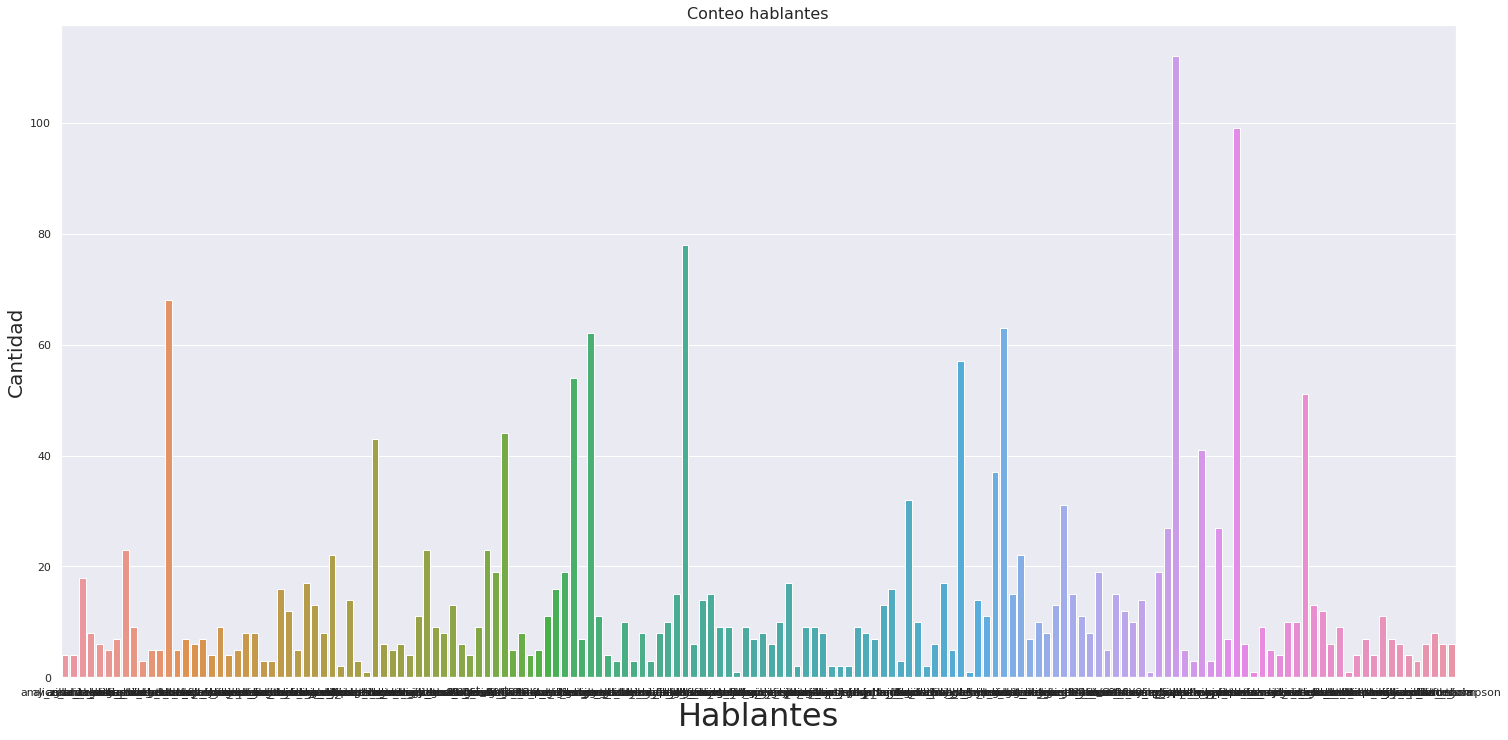

In [ ]:
plt.title('Conteo hablantes', size=16)
sns.countplot(speech_df.speechers)
sns.set(rc = {'figure.figsize':(25,12)})
plt.ylabel('Cantidad', size=20)
plt.xlabel('Hablantes', size=32)
plt.show()

Podemos ver con el gráfico que hay hablantes con mucha más data. Por lo que disponemos de funciones para aumentar la data.

In [ ]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range) # cambia el orden del array, coloca en la posición shift_range al principio


# taking any example and checking for techniques.
path = np.array(speech_df.path)[1]
data, sample_rate = librosa.load(path)

Revisamos el audio

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} speecher'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} speecher'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

/content/drive/MyDrive/universidad/train/margaret_edith/Medio Ambiente_0TAl3YEMM0s_4105_4148.wav


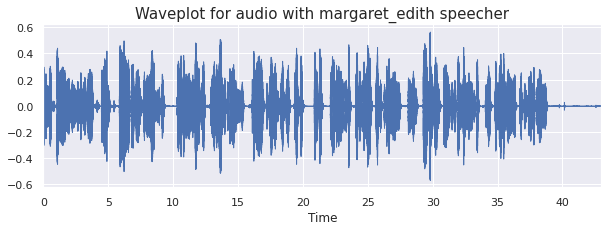

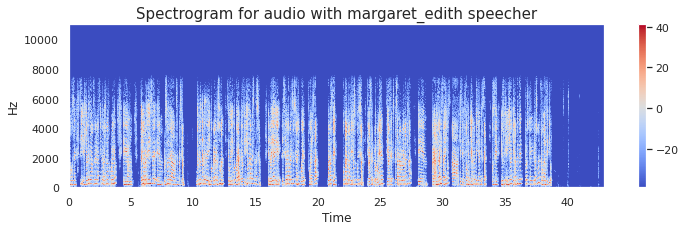

In [ ]:
speecher = "margaret_edith"
path = np.array(speech_df.path[speech_df.speechers==speecher])[2]
print(path)
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, speecher)
create_spectrogram(data, sampling_rate, speecher)
Audio(path)

Un solo hablante, son discursos por ende podemos sacar un puñado de la data, sus features y mientras menos audios hayan por integrante, más data sacamos de un sólo audio.

La feature que estudiaremos será MFCC. Por qué? porque se ha usado anteriormente para reconocer hablantes y ha funcionado bien.

* [Reconociendo a qué pajaro pertenece el sonido](https://towardsdatascience.com/recurrent-neural-nets-for-audio-classification-81cb62327990)

* [Reconociendo hablantes con LSTM](https://www.researchgate.net/publication/322927149_Bengali_speech_recognition_A_double_layered_LSTM-RNN_approach#pf3)

22050


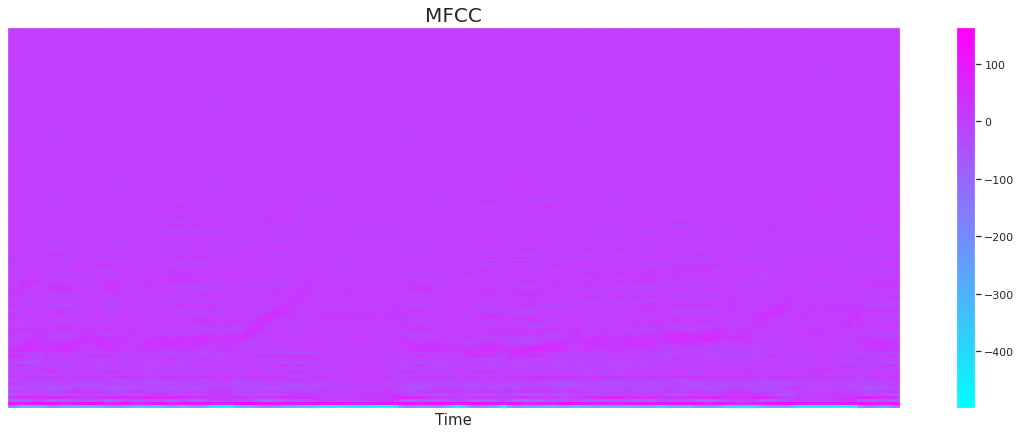

In [ ]:
hop_length = 512 #the default spacing between frames
n_fft = 255 #number of samples 
#cut the sample to the relevant times
y_cut, sr = librosa.load("drive/MyDrive/universidad/train/amy_zillah_elsie/extracto.wav", duration=4)
print(sr)
MFCCs = librosa.feature.mfcc(y_cut, sr=sr, n_mfcc=128)
fig, ax = plt.subplots(figsize=(20,7))
librosa.display.specshow(MFCCs,sr=sr, cmap='cool',hop_length=hop_length)
ax.set_xlabel('Time', fontsize=15)
ax.set_title('MFCC', size=20)
plt.colorbar()
plt.show()

In [ ]:
grouped_speechers = speech_df.groupby(["speechers"]).size().sort_values()
grouped_speechers

speechers
mary_agatha           1
elisabeth_walton      1
helen_loraine         1
thomas_clinton        1
lillian_gertrud       1
                   ... 
klas_albin           63
brigdet_delia        68
helene_barbara       78
peter_l              99
marion_elsie        112
Length: 162, dtype: int64

Necesitamos que todos nuestros speechers tengan en lo posible 112 muestras.

In [ ]:
speech_df["speecher_size"] = speech_df["speechers"].apply(lambda x: grouped_speechers[x])
speech_df.sort_values(by=["speecher_size"], ascending=False)

,speechers,path,speecher_size
1707,marion_elsie,/content/drive/MyDrive/universidad/train/mario...,112
1651,marion_elsie,/content/drive/MyDrive/universidad/train/mario...,112
1725,marion_elsie,/content/drive/MyDrive/universidad/train/mario...,112
1724,marion_elsie,/content/drive/MyDrive/universidad/train/mario...,112
1723,marion_elsie,/content/drive/MyDrive/universidad/train/mario...,112
...,...,...,...
346,elisabeth_walton,/content/drive/MyDrive/universidad/train/elisa...,1
1254,lillian_gertrud,/content/drive/MyDrive/universidad/train/lilli...,1
1595,mary_agatha,/content/drive/MyDrive/universidad/train/mary_...,1
1945,percival_wayland,/content/drive/MyDrive/universidad/train/perci...,1


In [ ]:
import random
from collections import defaultdict
def get_features(speech_df):
    """
    obtiene las features basadas en MFCC para los hablantes.
    Si los hablantes tienen menos que el hablante con mayor cantidad de audios
    va haciendo offset mediante el archivo.

    Por ejemplo si la razon del hablante es 5 : 2, correra 2 veces cada uno de
    los 4 archivos, y, con una probabilidad de 0.5 escogera añadir un archivo
    mas en ambos archivos, lo que deberia tender a 1 cada 2 a la larga.
    """
    max_features = 112
    features=[]
    files_collected_times = defaultdict(int)
    labels=[]
    for path, speecher, speecher_size in zip(speech_df.path, speech_df.speechers, speech_df.speecher_size):
        for val in range(max_features // speecher_size):
          try:
            y, sample_rate = librosa.load(path, duration=4, offset = val * 4)
            data = np.mean(
                    librosa.feature.mfcc(y, sr=sr, n_mfcc=256).T, axis=0,
                  )
            features.append(data)
            labels.append(speecher)
            files_collected_times[path] += val
          except ValueError:
            print("no more data available for", speecher, path, "offset", val * 4)
            break

        # probabilidad para guardar otro audio con offset
        missing_for_prob =  max_features / speecher_size - (max_features // speecher_size)

        if missing_for_prob > 0 and random.random() < missing_for_prob:
            try:
              y, sample_rate = librosa.load(path, duration=4 * (val + 1))
              data = np.mean(
                      librosa.feature.mfcc(y, sr=sr, n_mfcc=128).T, axis=0,
                    )
              features.append(data)
              labels.append(speecher)
              files_collected_times[path] += 1
            except ValueError:  
              print("no more data available for", speecher)
    return(features, labels, files_collected_times)

In [ ]:
X, Y, times_collected_by_file = get_features(speech_df)

NameError: ignored

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,labels
0,-200.167358,141.357056,-24.841578,54.100090,-18.617785,-5.703780,-4.518502,-22.320616,-19.372757,-21.621819,...,0.161999,0.064788,0.007159,0.342895,0.230065,0.271644,0.094541,-0.333794,0.131841,agda_thorilda_viktoria
1,-304.835632,84.120712,-24.813208,38.606930,-18.673161,0.927359,-0.645266,-10.550078,-15.730280,-9.842849,...,-0.098683,-0.301991,-0.056987,-0.192074,-0.235469,0.015235,0.065760,-0.048015,0.090633,agda_thorilda_viktoria
2,-154.544067,140.777328,-46.185757,43.924633,-32.489040,5.663497,0.824449,-15.910819,-24.242722,-13.422091,...,0.203648,0.147873,-0.145104,0.214517,0.471627,0.046985,-0.003816,0.010047,0.231506,agda_thorilda_viktoria
3,-151.866333,139.620178,-52.292561,46.575092,-34.591705,3.868956,3.629763,-19.465214,-24.020191,-13.778741,...,-0.127963,0.197725,0.046133,-0.071042,0.141769,0.384428,0.298581,-0.034998,-0.175125,agda_thorilda_viktoria
4,-167.666702,122.390762,-48.780556,54.792427,-37.371910,6.513307,-1.207446,-15.670013,-22.933022,-15.478563,...,-0.118177,-0.070025,0.065739,0.066040,0.391547,0.122030,-0.190255,0.036004,-0.433475,agda_thorilda_viktoria


In [ ]:
sorted_values = Features.groupby(["labels"]).size().sort_values()
actual_sample = [(sorted_values[index], index) for index in sorted_values.index.values]
for sample, speecher in actual_sample:
    print(dict(filter(lambda x: speecher in x[0], times_collected_by_file.items())))
    break

{'C:\\Users\\Admn\\Desktop\\train\\robert_williams\\extracto.wav': 91}


In [ ]:
sorted_values[0:20]

labels
robert_williams      14
percival_wayland     22
gerda_ulrika         28
reginald_charles     34
charles_joseph       40
augusta_charlotta    44
johan_hansen         45
john_henry           46
johan_emil           49
lillian_gertrud      51
bertram_frank        51
ernest_james         52
thomas_clinton       53
constance_mirium     55
aurora_adelia        56
peter_henry          58
mary_conover         59
jessie_wills         59
paul_edvin           59
daniel_j             60
dtype: int64

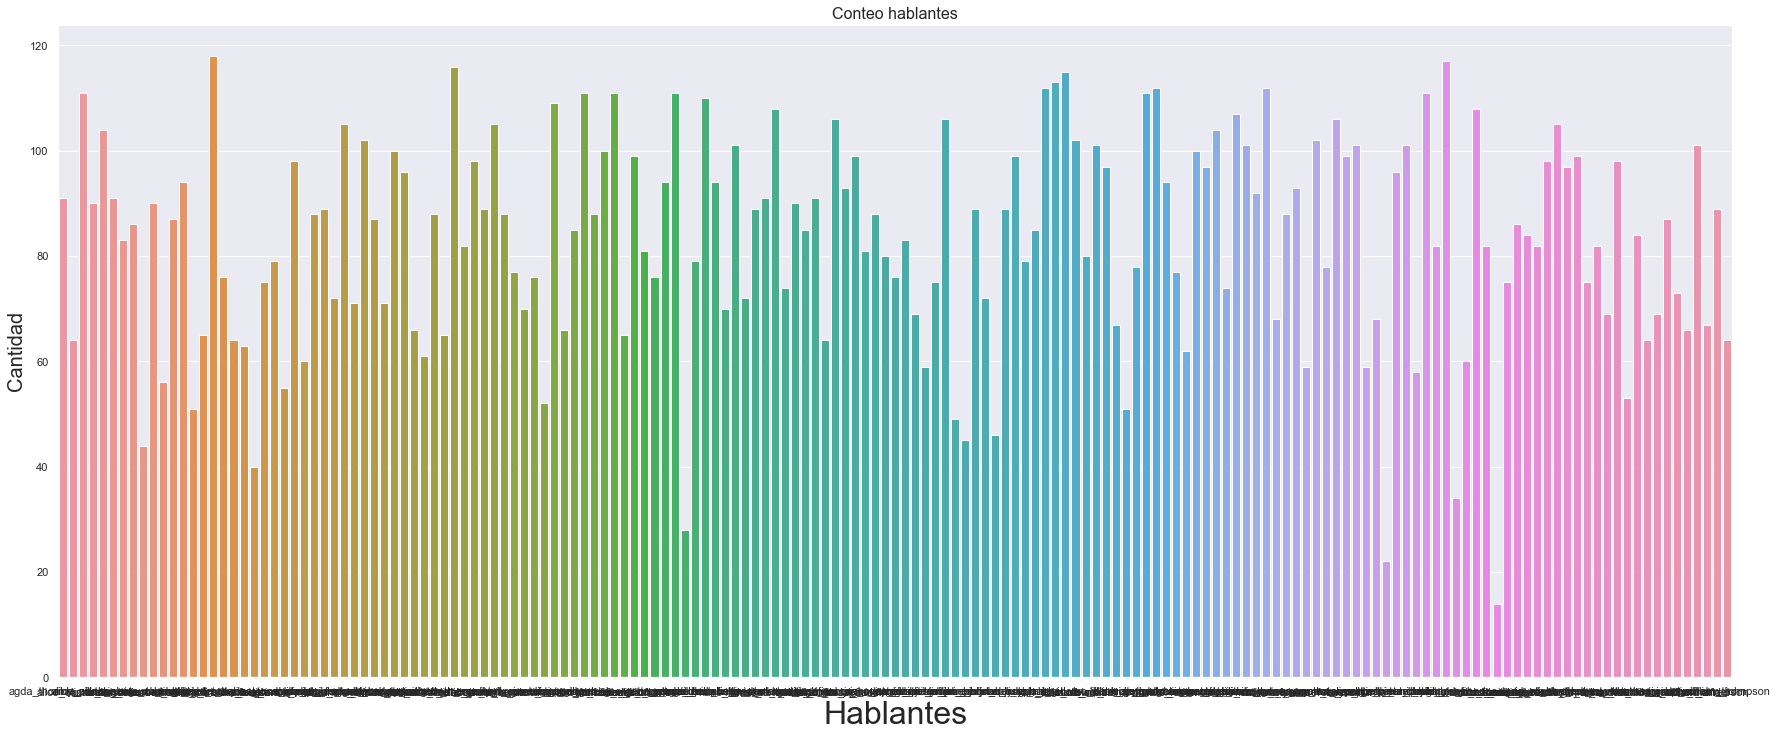

In [ ]:
plt.title('Conteo hablantes', size=16)
sns.countplot(Features.labels)
sns.set(rc = {'figure.figsize':(25,12)})
plt.ylabel('Cantidad', size=20)
plt.xlabel('Hablantes', size=32)
plt.show()

La data está más pareja pero aún hay algunas labels menos representadas.

In [ ]:
Features = pd.read_csv("features.csv")
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print(x_train[0])

(10418, 128) (10418, 167) (3473, 128) (3473, 167)
(10418, 128, 1) (10418, 167) (3473, 128, 1) (3473, 167)
[[ 0.1046583 ]
 [ 1.2447014 ]
 [-0.70083709]
 [-0.89869766]
 [-0.64072908]
 [-2.12060462]
 [-0.04025575]
 [-0.37489938]
 [-0.43690869]
 [-0.65795743]
 [-0.39031627]
 [ 1.04750278]
 [-0.00498831]
 [ 0.34722362]
 [ 0.82137387]
 [ 0.07457534]
 [-0.55955482]
 [ 1.16709934]
 [-0.04860031]
 [-1.45615524]
 [-0.40633987]
 [-1.66474883]
 [-1.85617224]
 [-0.83338098]
 [-0.87955626]
 [-0.25600772]
 [ 1.03432937]
 [ 1.13971878]
 [ 1.88832325]
 [ 1.92992427]
 [ 1.281401  ]
 [ 1.42096595]
 [ 0.50928434]
 [ 0.55268823]
 [ 0.45369589]
 [ 0.1440324 ]
 [-0.02262706]
 [-0.40762468]
 [-0.52178991]
 [-0.45663047]
 [-0.63790346]
 [-1.2646099 ]
 [-1.02408428]
 [-0.86269003]
 [-0.57997244]
 [-0.47593746]
 [-0.75734954]
 [-1.76941908]
 [-1.81708269]
 [-0.78871958]
 [-0.9573814 ]
 [-1.25513986]
 [-1.57250501]
 [-1.02261893]
 [-0.48474351]
 [-0.60719226]
 [-0.64013276]
 [ 0.13717773]
 [ 0.96546512]
 [-0.0488

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf

In [ ]:
def lstm_deep_model():
    model = tf.keras.Sequential([
      tf.keras.layers.LSTM(149, return_sequences=True, input_shape=(128, 1)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
      tf.keras.layers.Dense(units=167, activation='softmax')
    ])
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
    return model
model_lstm_deep_3 = lstm_deep_model()
model_lstm_deep_3.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 128, 149)          89996     
                                                                 
 bidirectional_25 (Bidirecti  (None, 128, 256)         284672    
 onal)                                                           
                                                                 
 bidirectional_26 (Bidirecti  (None, 128, 256)         394240    
 onal)                                                           
                                                                 
 bidirectional_27 (Bidirecti  (None, 128, 256)         394240    
 onal)                                                           
                                                                 
 bidirectional_28 (Bidirecti  (None, 256)              394240    
 onal)                                                

In [ ]:
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.4, verbose=0, patience=2)
ealry_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
lstm_history = model_lstm_deep_3.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test), callbacks=[rlrp, ealry_stop])

Epoch 1/100
163/163 [==============================] - 32s 123ms/step - loss: 4.5925 - accuracy: 0.0477 - val_loss: 4.2570 - val_accuracy: 0.0792 - lr: 0.0010
Epoch 2/100
163/163 [==============================] - 17s 106ms/step - loss: 4.0974 - accuracy: 0.0982 - val_loss: 3.9150 - val_accuracy: 0.1224 - lr: 0.0010
Epoch 3/100
163/163 [==============================] - 17s 106ms/step - loss: 3.6599 - accuracy: 0.1629 - val_loss: 3.5571 - val_accuracy: 0.1779 - lr: 0.0010
Epoch 4/100
163/163 [==============================] - 17s 106ms/step - loss: 3.3834 - accuracy: 0.2001 - val_loss: 3.3624 - val_accuracy: 0.2151 - lr: 0.0010
Epoch 5/100
163/163 [==============================] - 17s 106ms/step - loss: 3.0979 - accuracy: 0.2474 - val_loss: 3.2065 - val_accuracy: 0.2275 - lr: 0.0010
Epoch 6/100
163/163 [==============================] - 17s 104ms/step - loss: 2.8772 - accuracy: 0.2866 - val_loss: 3.0406 - val_accuracy: 0.2640 - lr: 0.0010
Epoch 7/100
163/163 [=========================

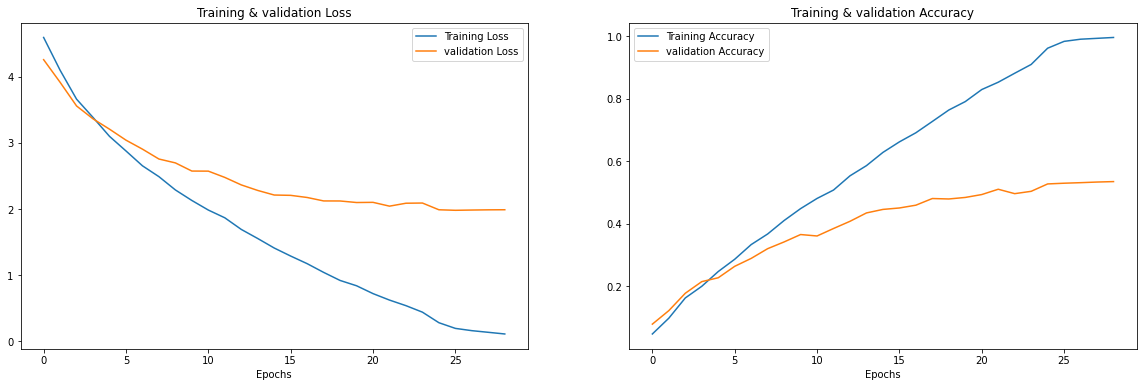

In [ ]:
def plot_performance(history):
  epochs = [i for i in range(len(history.history["loss"]))]
  fig , ax = plt.subplots(1,2)
  train_acc = history.history['accuracy']
  train_loss = history.history['loss']
  test_acc = history.history['val_accuracy']
  test_loss = history.history['val_loss']

  fig.set_size_inches(20,6)
  ax[0].plot(epochs , train_loss , label = 'Training Loss')
  ax[0].plot(epochs , test_loss , label = 'validation Loss')
  ax[0].set_title('Training & validation Loss')
  ax[0].legend()
  ax[0].set_xlabel("Epochs")

  ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
  ax[1].plot(epochs , test_acc , label = 'validation Accuracy')
  ax[1].set_title('Training & validation Accuracy')
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  plt.show()

plot_performance(lstm_history)

Intentamos hacer un modelo regularizado

In [ ]:
from keras.regularizers import L1L2

def lstm_l1l2_deep_model():
    model = tf.keras.Sequential([
      tf.keras.layers.LSTM(96, return_sequences=True, input_shape=(128, 1), kernel_regularizer=L1L2(0.01, 0.01)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(96,  return_sequences=True, kernel_regularizer=L1L2(0.01, 0.01))),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, kernel_regularizer=L1L2(0.01, 0.01))),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(96, return_sequences=True, kernel_regularizer=L1L2(0.01, 0.01))),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,  kernel_regularizer=L1L2(0.01, 0.01))),
      tf.keras.layers.Dense(units=167, activation='softmax')
    ])
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
    return model
model_lstm_l1l2 = lstm_l1l2_deep_model()
model_lstm_l1l2.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_69 (LSTM)              (None, 128, 96)           37632     
                                                                 
 bidirectional_51 (Bidirecti  (None, 128, 192)         148224    
 onal)                                                           
                                                                 
 bidirectional_52 (Bidirecti  (None, 128, 64)          57600     
 onal)                                                           
                                                                 
 bidirectional_53 (Bidirecti  (None, 128, 192)         123648    
 onal)                                                           
                                                                 
 bidirectional_54 (Bidirecti  (None, 256)              328704    
 onal)                                               

In [ ]:
lstm_history = model_lstm_l1l2.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test), callbacks=[rlrp, ealry_stop])

Epoch 1/100
163/163 [==============================] - 29s 105ms/step - loss: 52.5949 - accuracy: 0.0111 - val_loss: 5.6362 - val_accuracy: 0.0084 - lr: 0.0010
Epoch 2/100
163/163 [==============================] - 13s 78ms/step - loss: 5.5810 - accuracy: 0.0078 - val_loss: 5.5702 - val_accuracy: 0.0058 - lr: 0.0010
Epoch 3/100
163/163 [==============================] - 13s 78ms/step - loss: 5.5622 - accuracy: 0.0074 - val_loss: 5.5578 - val_accuracy: 0.0058 - lr: 0.0010
Epoch 4/100
163/163 [==============================] - 13s 78ms/step - loss: 5.5516 - accuracy: 0.0083 - val_loss: 5.5515 - val_accuracy: 0.0063 - lr: 0.0010
Epoch 5/100
163/163 [==============================] - 13s 78ms/step - loss: 5.5463 - accuracy: 0.0080 - val_loss: 5.5453 - val_accuracy: 0.0058 - lr: 0.0010
Epoch 6/100
163/163 [==============================] - 13s 79ms/step - loss: 5.5426 - accuracy: 0.0079 - val_loss: 5.5455 - val_accuracy: 0.0058 - lr: 0.0010
Epoch 7/100
163/163 [=============================

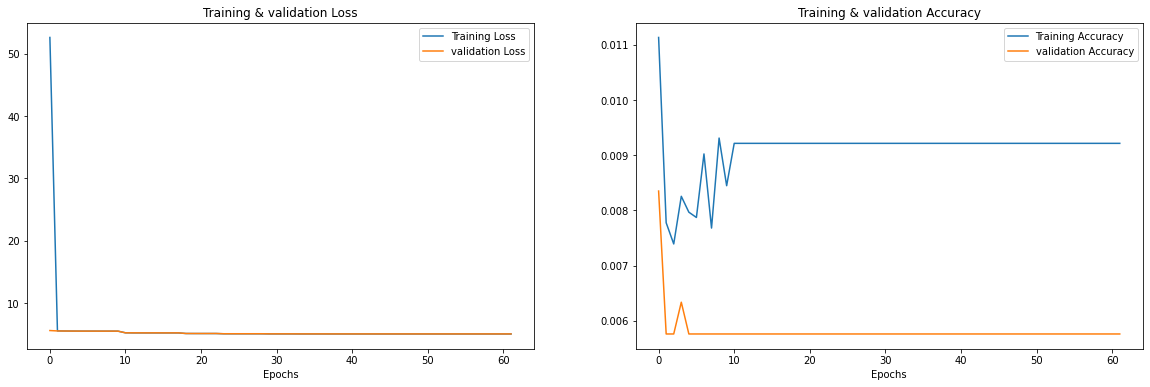

In [ ]:
plot_performance(lstm_history)

Hacer Regularización L1 L2 no mejoró en nada, es más, empeoró bastante.

In [ ]:
def lstm_simple_model():
    model = tf.keras.Sequential([
      tf.keras.layers.LSTM(128, return_sequences=True, input_shape=(128, 1)),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(162,  return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(162, return_sequences=True)),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(162,  return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(162,  return_sequences=True)),
      tf.keras.layers.Dropout(0.2), 
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(162)),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(256),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(units=167, activation='softmax')
    ])
    model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
    return model
model_lstm_simple = lstm_simple_model()
model_lstm_simple.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_168 (LSTM)             (None, 128, 128)          66560     
                                                                 
 dropout_117 (Dropout)       (None, 128, 128)          0         
                                                                 
 bidirectional_136 (Bidirect  (None, 128, 324)         377136    
 ional)                                                          
                                                                 
 bidirectional_137 (Bidirect  (None, 128, 324)         631152    
 ional)                                                          
                                                                 
 dropout_118 (Dropout)       (None, 128, 324)          0         
                                                                 
 bidirectional_138 (Bidirect  (None, 128, 324)       

In [ ]:
simple_lstm_history = model_lstm_simple.fit(x_train, y_train, batch_size=64, epochs=100, validation_data=(x_test, y_test), callbacks=[rlrp, ealry_stop])

Epoch 1/100
163/163 [==============================] - 62s 266ms/step - loss: 5.0331 - accuracy: 0.0125 - val_loss: 4.6455 - val_accuracy: 0.0394 - lr: 0.0010
Epoch 2/100
163/163 [==============================] - 36s 222ms/step - loss: 4.6442 - accuracy: 0.0345 - val_loss: 4.3777 - val_accuracy: 0.0818 - lr: 0.0010
Epoch 3/100
163/163 [==============================] - 36s 220ms/step - loss: 4.3767 - accuracy: 0.0618 - val_loss: 4.0115 - val_accuracy: 0.1120 - lr: 0.0010
Epoch 4/100
163/163 [==============================] - 36s 221ms/step - loss: 4.1682 - accuracy: 0.0794 - val_loss: 3.8449 - val_accuracy: 0.1448 - lr: 0.0010
Epoch 5/100
163/163 [==============================] - 36s 220ms/step - loss: 4.0092 - accuracy: 0.0985 - val_loss: 3.7200 - val_accuracy: 0.1670 - lr: 0.0010
Epoch 6/100
163/163 [==============================] - 36s 222ms/step - loss: 3.8556 - accuracy: 0.1229 - val_loss: 3.4806 - val_accuracy: 0.1929 - lr: 0.0010
Epoch 7/100
163/163 [=========================

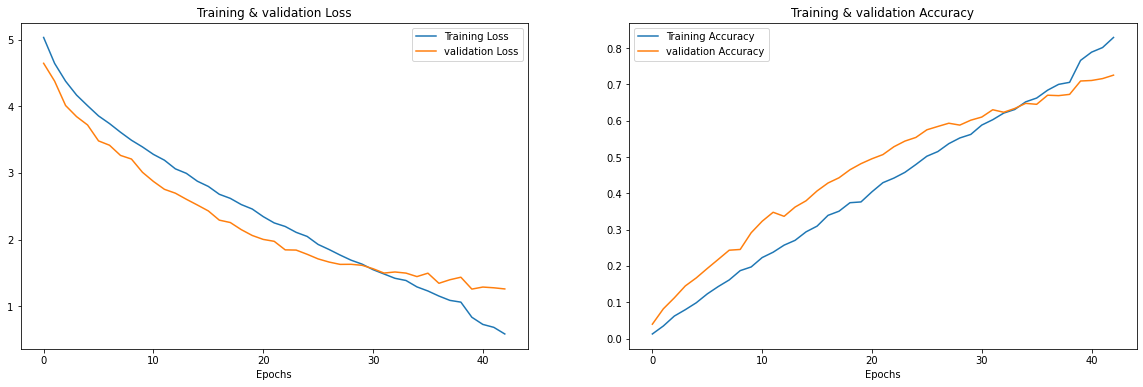

In [ ]:
plot_performance(simple_lstm_history)

In [ ]:
# predicting on test data.
def prepare_data_for_prediction(scaler):
    test_files = '/content/drive/MyDrive/universidad/test/' 
    file_paths = []
    features = []
    failures = []
    wav_files = os.listdir(test_files)
    print(len(wav_files))
    for wav_file in wav_files:
        file_paths.append(test_files + wav_file)
    for index, path in enumerate(file_paths):
        if index % 10 == 0:
          print(index, path)
        try:
          y, sample_rate = librosa.load(path, duration=4)
          data = np.mean(
                  librosa.feature.mfcc(y, sr=sample_rate, n_mfcc=128).T, axis=0,
                )
          features.append(data)  
        except ValueError:
              failures.append(index)
    for failure in sorted(failures, reverse=True):
        print(f"failure in {file_paths.pop(failure)}")
    to_predict_df = pd.DataFrame(features)
    to_predict_df.head()
    values_to_predict = to_predict_df.iloc[: ,:].values
    values_to_predict = scaler.transform(values_to_predict)
    values_to_predict = np.expand_dims(values_to_predict, axis=2)
    return values_to_predict, file_paths

values_to_predict, files_to_predict = prepare_data_for_prediction(scaler)

In [ ]:
def do_prediction(model, scaler, values_to_predict = None, files = None):
    if values_to_predict is None:
      values_to_predict, files = prepare_data_for_prediction(scaler)
    print(values_to_predict.shape)
    prediction = model.predict(values_to_predict)
    labels = encoder.inverse_transform(prediction)
    predictions = []
    for index, label in enumerate(labels):
        predictions.append(label[0])
    treated_files = [file_.split("/")[-1] for file_ in files]
    denoised_pred_df  = pd.DataFrame(treated_files, columns=["Id"])
    denoised_pred_df["Expected"] = predictions
    denoised_pred_df.head()
    return denoised_pred_df
pred_df = do_prediction(model_lstm_deep_3, scaler, values_to_predict, files_to_predict)

(957, 128, 1)


In [ ]:
pred_df = do_prediction(model_lstm_simple, scaler, values_to_predict, files_to_predict)
pred_df.to_csv("submission_lstm_dropout_deep.csv", index=False)

(957, 128, 1)
